In [3]:
# Install pytesseract
!pip install pytesseract

# Install Tesseract-OCR using apt-get
!sudo apt-get install tesseract-ocr

!pip install easyocr
# You might also want to install specific language packages if needed, for example:
# !sudo apt-get install tesseract-ocr-eng  # For English


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,626 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [4]:
from transformers import YolosFeatureExtractor, YolosForObjectDetection
from PIL import Image
import requests
import numpy as np
import cv2
import torch
import torchvision.ops as ops
from torchvision.ops import nms
import cv2
import matplotlib.pyplot as plt
import easyocr


In [15]:
url = 'https://engage.gov.bc.ca/app/uploads/sites/121/2023/12/Specialty-Plates1.jpg'
image = Image.open(requests.get(url, stream=True).raw)
feature_extractor = YolosFeatureExtractor.from_pretrained('nickmuchi/yolos-small-finetuned-license-plate-detection')
model = YolosForObjectDetection.from_pretrained('nickmuchi/yolos-small-finetuned-license-plate-detection')
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding face mask detection classes
logits = outputs.logits
bboxes = outputs.pred_boxes

In [16]:
logits = logits.squeeze(0)  # Remove the first dimension if it's 1
probabilities = torch.softmax(logits, dim=-1)
confidence_scores = probabilities[:, 1]

# Set a confidence threshold and filter out low-confidence bounding boxes
confidence_threshold = 0.9  # Adjust this value as needed
mask = confidence_scores > confidence_threshold
filtered_scores = confidence_scores[mask]
filtered_bboxes = bboxes.squeeze(0)[mask]  # Apply the mask

print(f"Total boxes: {len(bboxes.squeeze(0))}, After filtering: {len(filtered_bboxes)}")

# Convert bounding boxes to [x_min, y_min, x_max, y_max] format
x_center, y_center, width, height = filtered_bboxes.unbind(-1)
x_min = x_center - (width / 2)
y_min = y_center - (height / 2)
x_max = x_center + (width / 2)
y_max = y_center + (height / 2)
filtered_bboxes_xyxy = torch.stack((x_min, y_min, x_max, y_max), dim=1)

# Apply NMS
iou_threshold = 0.2  # Adjust this value as needed
nms_indices = nms(filtered_bboxes_xyxy, filtered_scores, iou_threshold)

# Final bounding boxes after NMS
final_bboxes = filtered_bboxes_xyxy[nms_indices]

print(f"After NMS: {len(final_bboxes)}")

# Select the best bounding box
if len(final_bboxes) > 0:
    best_bbox_index = torch.argmax(filtered_scores[nms_indices])
    best_bbox = final_bboxes[best_bbox_index]
    print(f"Best bbox (x_min, y_min, x_max, y_max): {best_bbox}")
else:
    best_bbox = None
    print("No bounding box met the criteria.")


Total boxes: 100, After filtering: 1
After NMS: 1
Best bbox (x_min, y_min, x_max, y_max): tensor([0.4011, 0.5519, 0.5278, 0.6611], grad_fn=<SelectBackward0>)


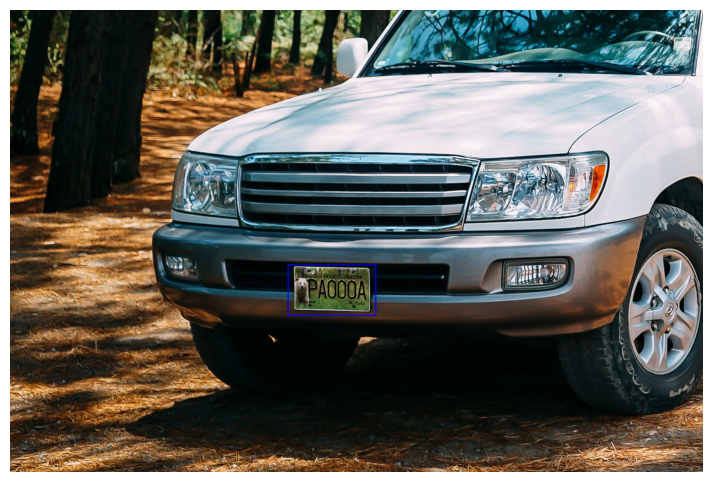

In [17]:
img_width, img_height = image.size

# Convert the original PIL image to OpenCV format for visualization
image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

x_min, y_min, x_max, y_max = best_bbox
start_point = (int(x_min * img_width), int(y_min * img_height))
end_point = (int(x_max * img_width), int(y_max * img_height))
color = (255, 0, 0)  # Blue color in BGR
thickness = 2
image_cv = cv2.rectangle(image_cv, start_point, end_point, color, thickness)

# Convert back to RGB for Matplotlib
image_cv_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(image_cv_rgb)
plt.axis('off')
plt.show()


License Plate Number: British Columbia PAOooa| BC Parks


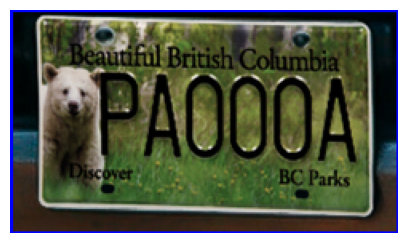

In [18]:
x_min, y_min, x_max, y_max = best_bbox
img_width, img_height = image.size

# Convert the bounding box coordinates from normalized to absolute pixel values
x_min_abs = int(x_min * img_width)
y_min_abs = int(y_min * img_height)
x_max_abs = int(x_max * img_width)
y_max_abs = int(y_max * img_height)

# Crop the license plate region from the original OpenCV image
license_plate_image = image_cv[y_min_abs:y_max_abs, x_min_abs:x_max_abs]

# Initialize EasyOCR Reader
reader = easyocr.Reader(['en'])  # Add any other languages you need

# Read text from the cropped license plate image
results = reader.readtext(license_plate_image)

# Process EasyOCR results to extract the license plate number
# This example simply concatenates recognized text elements, but you might need more sophisticated processing
license_plate_number = ' '.join([result[1] for result in results])

# Display the license plate number
print(f"License Plate Number: {license_plate_number}")

# Optionally, display the cropped license plate image
plt.figure(figsize=(5, 3))
plt.imshow(cv2.cvtColor(license_plate_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
